
# Метод Ньютона

## Метод Ньютона

- Классический метод Ньютона: $\alpha_k \equiv 1$
- Демпфированный метод Ньютона: $\alpha_k$ выбирается на каждой итерации по заданному правилу

```python
def NewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    while True:
        
        h = ComputeNewtonStep(x, f, **kwargs)
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
    return x

```

## Теорема сходимости (Ю. Е. Нестеров Введение в выпуклую оптимизацию, $\S$ 1.2)

**Теорема.** Пусть функция $f(x)$
- дважды дифференцируема и её гессиан удовлетворяет условию Липшица с константой $M$
- существует точка локального минимума с положительно определённым гессианом

$$
f''(x^*) \succeq l\mathbf{I}, \; l > 0
$$

- начальная точка $x_0$ достаточно близка к точке минимума, в частности

$$
\|x_0 - x^*\|_2 \leq \frac{2l}{3M}
$$

Тогда метод Ньютона сходится **квадратично**:

$$
\|x_{k+1} - x^* \|_2 \leq \dfrac{M\|x_k - x^*\|^2_2}{2 (l - M\|x_k - x^*\|_2)}
$$

### Пример

Применим метод Ньютона для поиска корня следующей функции

$$
\varphi(t) = \dfrac{t}{\sqrt{1+t^2}}
$$

и определим область сходимости.

## Аффинная инвариантность

Рассмотрим функцию $f(x)$ и невырожденное преобразование с матрицей $A$. 

Выясним, как изменится шаг метода Ньютона после преобразования $A$.

Пусть $x = Ay$ и $g(y) = f(Ay)$. Тогда

$$
g(y + u) \approx g(y) + \langle g'(y), u \rangle + \frac{1}{2} u^{\top} g''(y) u \to \min_{u}
$$

и

$$
u^* = -(g''(y))^{-1} g'(y) \qquad y_{k+1} = y_k - (g''(y_k))^{-1} g'(y_k)
$$

или

\begin{align*}
y_{k+1} & = y_k - (A^{\top}f''(Ay_k)A)^{-1} A^{\top}f'(Ay_k)\\
& = y_k - A^{-1}(f''(Ay_k))^{-1}f'(Ay_k)
\end{align*}

Таким образом,

$$
Ay_{k+1} = Ay_k - (f''(Ay_k))^{-1}f'(Ay_k) \quad x_{k+1} = x_k - (f''(x_k))^{-1}f'(x_k)
$$

Следовательно, направление метода Ньютона преобразуется при 

линейном преобразовани так же, как и координаты!

### Метод Ньютона с модификацией гессиана

- Как быть с возможной неположительной определённостью гессиана на некоторой итерации?
- Если $f''(x)$ неположительно определён, использовать положительно определённую матрицу $f''(x) + \Delta E$
- Матрицу $\Delta E$ можно выбирать различными способами исходя из следующей задачи
$$
\Delta E = \arg\min \|\Delta E\|, \quad \text{s.t. } f''(x) + \Delta E \succ 0
$$
    - $\|\cdot\|_2$: $\Delta E = \tau I$, где $\tau = \max(0, \delta - \lambda_{\min}(f''(x)))$, где $\delta > 0$ - заданная оценка снизу минимального собственного значения матрицы $f''(x) + \Delta E$
    - Чему равно $\Delta E$ при использовании $\|\cdot\|_F$?
    
- Поскольку оценку $\lambda(f''(x))$ обычно сложно вычислять на каждой итерации, возможно модифицировать процедуру вычисления разложения Холецкого матрицы $f''(x)$ так чтобы в итоге получилось разложение Холецкого для матрицы $f''(x) + \Delta E$

## Вычислительная сложность и эксперименты

Узкие места метода Ньютона:

- формирование и хранение гессиана
- решение систем линейных уравнений

$$
f''(x_k)h = -f'(x_k)
$$

### Сравнение с градиентным спуском

Вспомним задачу нахождения аналитического центра системы неравенств $Ax \leq 1$ при условии $|x_i| \leq 1$

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

$$
f'(x) - ? \quad f''(x) - ?
$$ 

In [15]:
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

n = 1000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10

#### Точное решение с помощью CVXPy

In [16]:
import cvxpy as cvx
x = cvx.Variable((n, 1))

obj = cvx.Minimize(cvx.sum(-cvx.log(1 - A.T * x)) - 
                   cvx.sum(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(solver="SCS", verbose=True, max_iters=1000)
print("Optimal value =", prob.value)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 205200, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
Variables n = 3200, constraints m = 6600
Cones:	soc vars: 3000, soc blks: 1000
	exp vars: 3600, dual exp vars: 0
Setup time: 7.73e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf      -inf       inf  1.97e-02 
   100| 1.62e+01  3.24e+00  9.84e-03 -8.77e+03 -8.60e+03  1.82e-13  1.02e+00 
   200| 1.44e+00  9.74e-01  1.69e-03 -1.94e+03 -1.93e+03  3.25e-13  2.02e+00 
   300| 4

#### Вспомогательные функции

In [17]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

#### Реализация метода Ньютона

In [18]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

#### Сравнение с градиентным спуском

In [19]:
newton = methods.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_newton = newton.solve(x0, tol=1e-6, max_iter=50, disp=True)

gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_gd = gd.solve(x0, tol=1e-6, max_iter=50, disp=True)

Required tolerance achieved!
Convergence in 14 iterations
Function value = -1368.2524882180878
Norm of gradient = 7.208022050152875e-10
Required tolerance achieved!
Convergence in 46 iterations
Function value = -1368.2524882180878
Norm of gradient = 8.728596652704076e-07


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


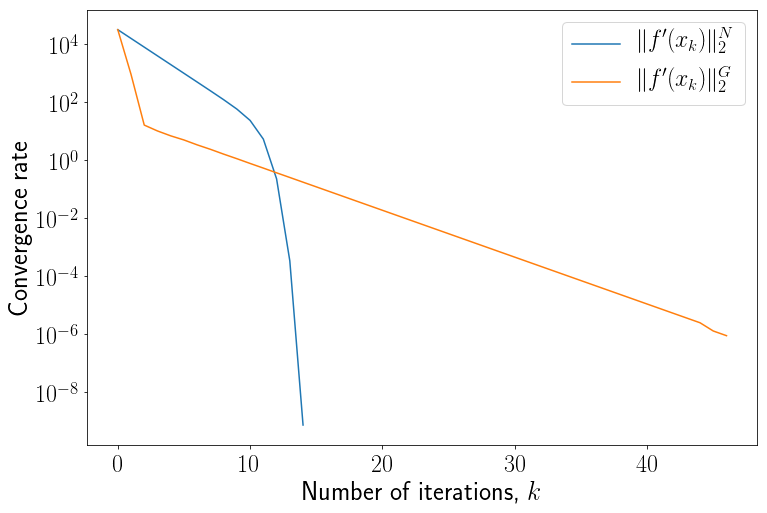

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="$\| f'(x_k) \|^{N}_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="$\| f'(x_k) \|^{G}_2$")
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Convergence rate", fontsize=26)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend(loc="best", fontsize=24)

#### Сравнение времени работы

In [21]:
%timeit newton.solve(x0, tol=1e-6, max_iter=50)
%timeit gd.solve(x0, tol=1e-6, max_iter=50)

494 ms ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


234 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Метод Ньютона даёт очень точное решение за длительное время
- Градиентный спуска даёт не очень точное решение, но гораздо быстрее
- Часто бывает, что очень точное решение не требуется, поэтому градиентный спуск может быть предпочтительнее

## Pro & Contra

Pro

- квадратичная сходимость вблизи решения
- высокая точность полученного решения
- аффинная инвариантность
- параметры слабо влияют на скорость сходимости

Contra

- необходимо хранить гессиан на каждой итерации: $O(n^2)$ памяти
- необходимо решать линейные системы: $O(n^3)$ операций
- гессиан может оказаться вырожден
- гессиан может не быть положительно определён $\to$ направление $-(f''(x))^{-1}f'(x)$ может не быть направлением убывания

## Сравнение с градиентным методом (Б.Т. Поляк Введение в оптимизацию, гл. 3, $\S$ 1 )

Метод | Скорость сходимости | Сложность | Аффинная инвариантность | Требования к $f(x)$
:---: | :---: | :---: | :---: | :---
Градиентный спуск | Глобально линейная | $O(n) + $ определение шага | Нет | Дифференцируема; градиент липшицев
Метод Ньютона | Локально квадратичная | $O(n^3) + $ определение шага | Да | Дважды диференцируема; гессиан липшицев, положительно определён


## Что дальше?

- **Сложность:** как избавиться от решения систем линейных уравнений и хранения гессиана?
- **Сходимость:** как совместить локально квадратичную и глобально линейную скорости? Желательно получить глобально квадратичную сходимость!
- Требования к $f(x)$ необходимо минимизировать
- Квазиньютоновские методы частично решают эти проблемы

## Резюме

1. Метод Ньютона
2. Теоремы сходимости
4. Сравнение с градиентным спуском
5. Эксперименты